# Collective Quantum Exhaustive Search Experiments
These are defiend by the instructions in an email from 13.2.24 from IA to DM and TM.

## Used external notebooks

In [3]:
from ipynb.fs.full.ansatz import get_twolocal

### Imports

In [4]:
from qiskit.quantum_info import SparsePauliOp
import networkx as nx
import random

from hamiltonians import gen_trans_ising_op, get_exact_ground, gen_maxcut_op, gen_maxcut_op_from_graph
from experiment_utils import *
from graphing import plot_VQE_evals_list

random.seed(7)

## Two-qubit experiments
These experiments are run on two types of examples:
-   Molecular Hamiltonians: H2 and HeH.
-   Transverse-Field Ising Model Hamiltonians.

For these, we will present:
-   The energy landscape sampled using all MUB states (without an appended ansatz).
-   VQE execution from the best 10 MUB states as initial points (awaiting Dekel's code to do this).

### Hamiltonian Generation

In [3]:
H2_ham_0_75 = SparsePauliOp(data= ['II', 'IZ', 'ZI', 'ZZ', 'XX'],
coeffs= [-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,  0.18206025+0.j])

HeH_ham_1 = SparsePauliOp(data= ['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'ZX', 'XZ', 'XX'],
coeffs= [-3.04506092+0.j,  0.50258052+0.j,  0.11926278+0.j, -0.50258052+0.j, 0.11926278+0.j, -0.13894646+0.j, -0.11926145+0.j,  0.11926145+0.j,  0.11714671+0.j])

molecular_hams = [H2_ham_0_75, HeH_ham_1]
molecular_descs = ["LiH, 0.75A, 2 qubits", "HeH, 1A, 2 qubits"]

transverse_hams = [gen_trans_ising_op(2, random.uniform(0,1), random.uniform(0,1)) for _ in range(2)]

### Calculate Landscape

===Calculating Molecular Landscapes===
attempting all MUB states over the operator SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,
  0.18206025+0.j])
Energy Landscape:


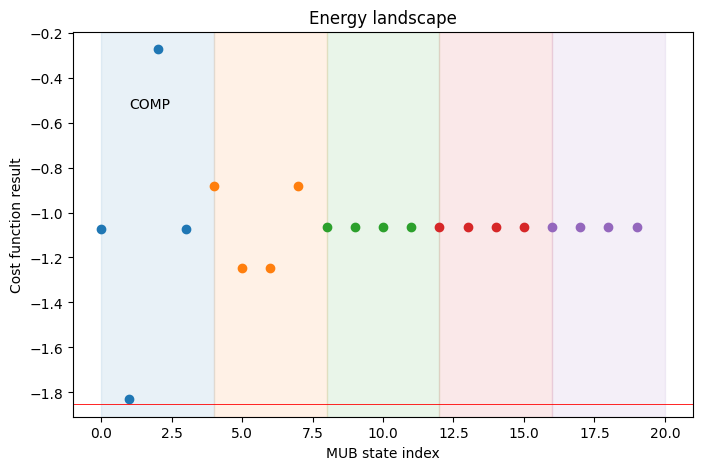

Energy Histogram:


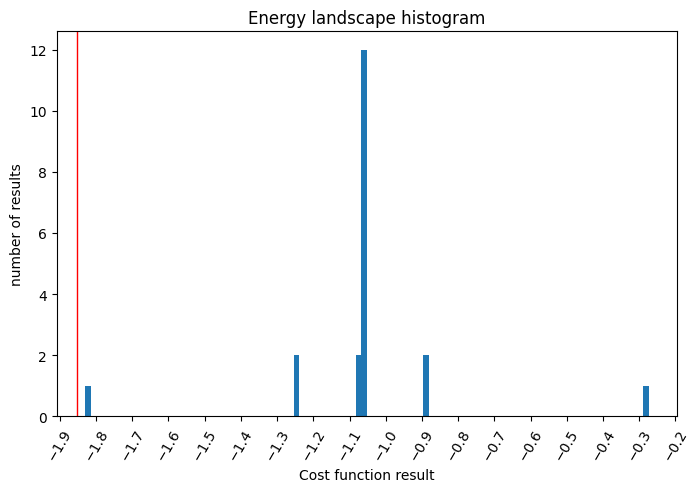

attempting all MUB states over the operator SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'ZX', 'XZ', 'XX'],
              coeffs=[-3.04506092+0.j,  0.50258052+0.j,  0.11926278+0.j, -0.50258052+0.j,
  0.11926278+0.j, -0.13894646+0.j, -0.11926145+0.j,  0.11926145+0.j,
  0.11714671+0.j])
Energy Landscape:


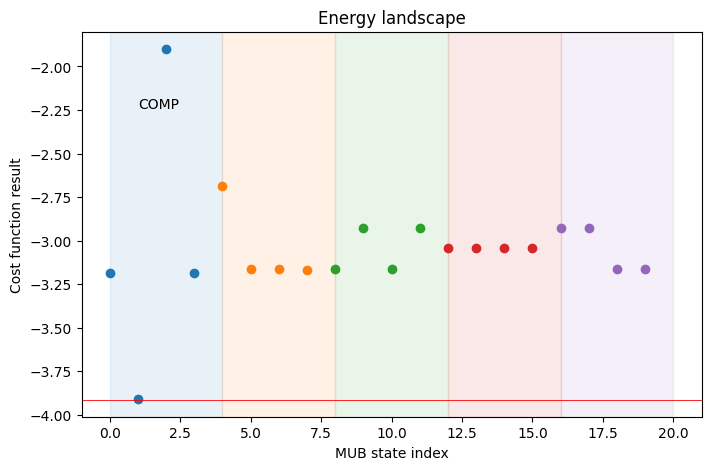

Energy Histogram:


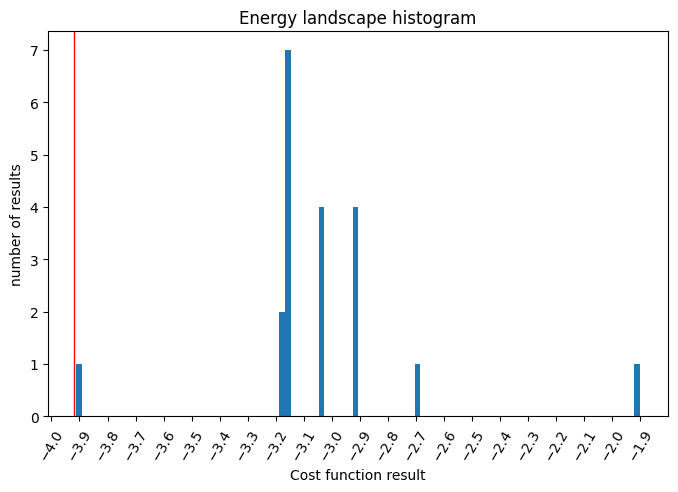

===Calculating Transverse Ising Landscapes===
attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.32383276+0.j, 0.15084917+0.j, 0.15084917+0.j])
Energy Landscape:


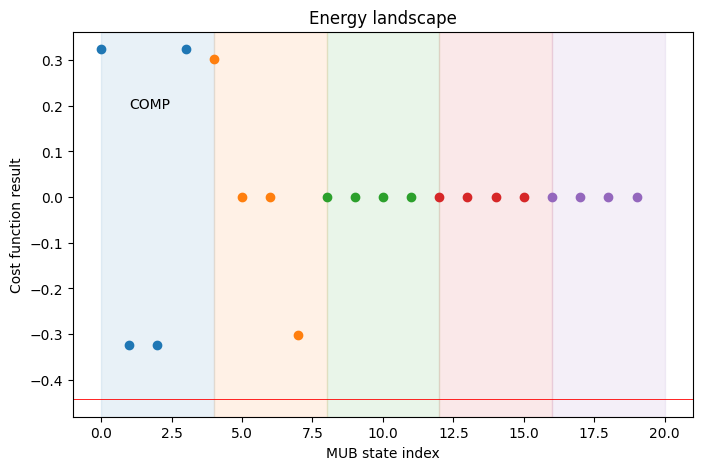

Energy Histogram:


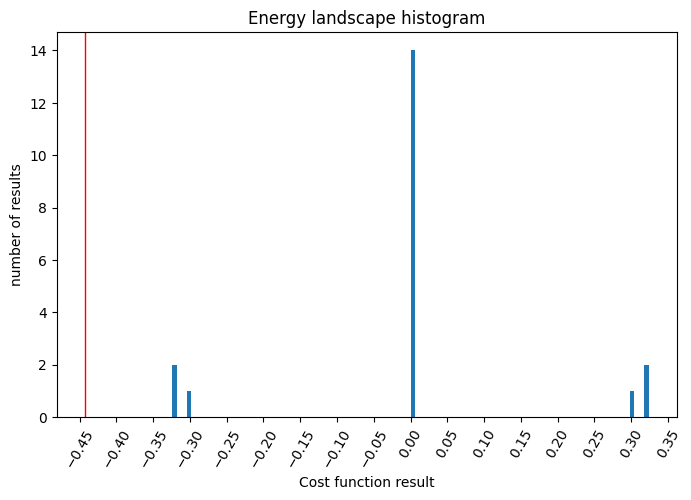

attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.65093447+0.j, 0.07243629+0.j, 0.07243629+0.j])
Energy Landscape:


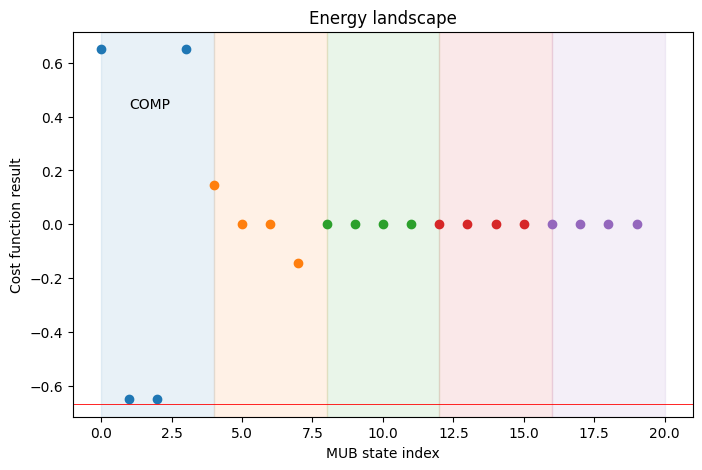

Energy Histogram:


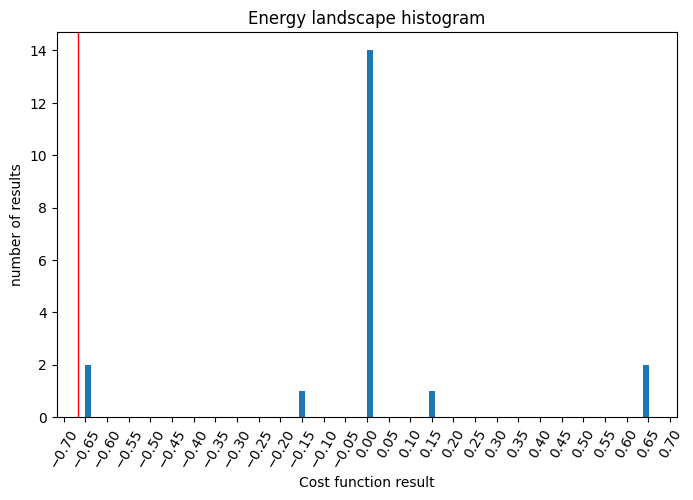

In [4]:
print("===Calculating Molecular Landscapes===")
molecular_landscapes = run_and_record_landscape_list(molecular_hams, n_mub_qubits=2)
print("===Calculating Transverse Ising Landscapes===")
transverse_landscapes = run_and_record_landscape_list(transverse_hams, n_mub_qubits=2)


### VQE Execution

The operator SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,
  0.18206025+0.j]) has the exact value -1.851311285646772.
Now trying to reach the value from the best and worst landscape points.
10: -1.5586667165367514
20: -1.8404198601162125
30: -1.8510411492169472
40: -1.8509294001100383
50: -1.851263160300927
60: -1.8513056389867162
70: -1.8513100077891738
80: -1.8513108096429673
90: -1.8513109475420981
100: -1.851310991028565
10: -1.8331419438294805
20: -1.832550336244683
30: -1.8451104091128037
40: -1.8503603981220644
50: -1.8511922029248409
60: -1.8512017751794545
70: -1.8512800811302248
80: -1.8512976414453974
90: -1.8512990725116554
100: -1.8512991867968833


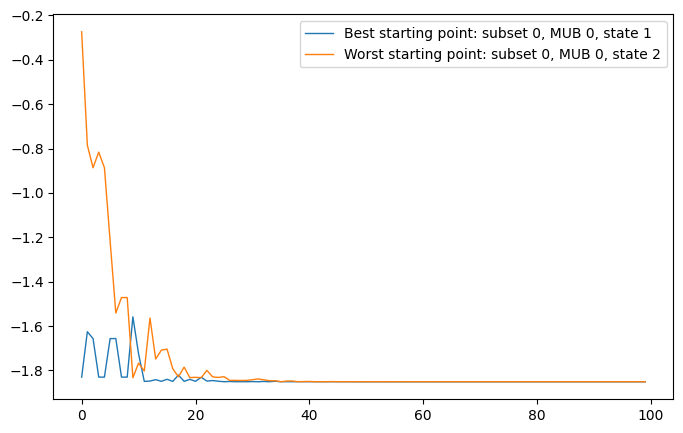

In [5]:
run_and_display_vqe_best_and_worst_expressive_2q(molecular_landscapes[0])

The operator SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,
  0.18206025+0.j]) has the exact value -1.851311285646772.
Now trying to reach the value from different MUB points.
running from state of index subset 0, MUB 0, state 1 and value -1.83030036
10: -1.5586667165367514
20: -1.8404198601162125
30: -1.8510411492169472
40: -1.8509294001100383
50: -1.851263160300927
60: -1.8513056389867162
70: -1.8513100077891738
80: -1.8513108096429673
90: -1.8513109475420981
100: -1.851310991028565
running from state of index subset 0, MUB 1, state 1 and value -1.24530027
10: -1.4082514031324864
20: -1.645752678672896
30: -1.8302016703447959
40: -1.84360264852992
50: -1.8490876494878932
60: -1.8500795114494717
70: -1.850763985165892
80: -1.8507825361509869
90: -1.8508492242669148
100: -1.8508860454066496
running from state of index subset 0, MUB 1, state 2 and value -1.24530027
10: -1.5633235758420605
20: -1.478

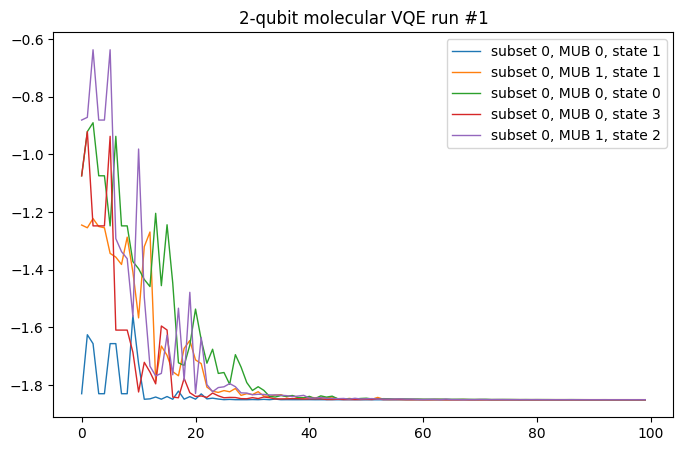

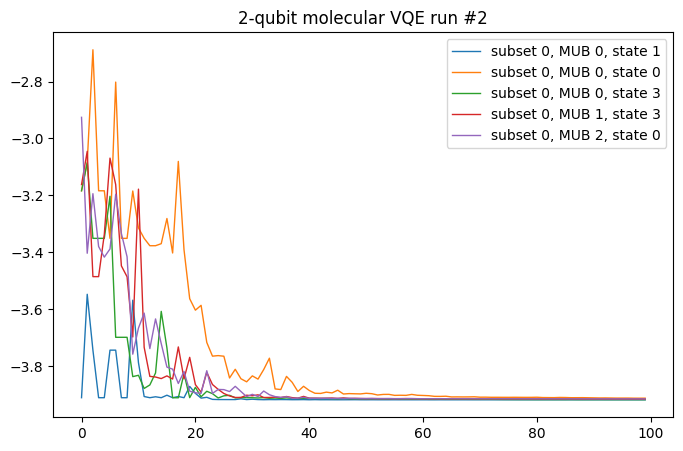

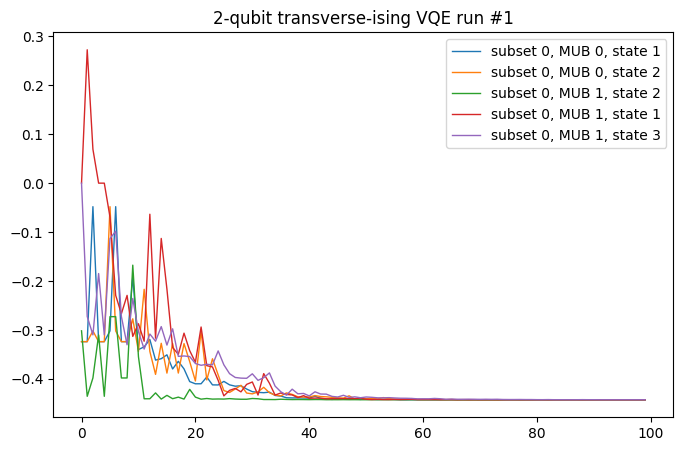

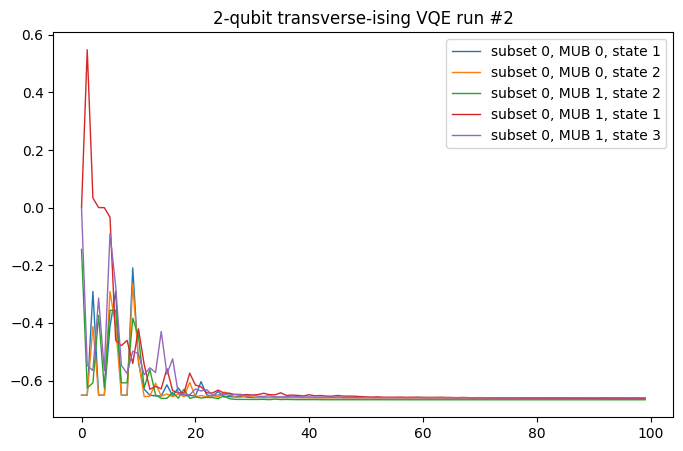

In [6]:
molecular_vqe_runs = run_and_record_vqe_expressive_2q_list(molecular_landscapes)
transverse_vqe_runs = run_and_record_vqe_expressive_2q_list(transverse_landscapes)
plot_VQE_evals_list(molecular_vqe_runs, "2-qubit molecular VQE run")
plot_VQE_evals_list(transverse_vqe_runs, "2-qubit transverse-ising VQE run")

## Three-qubit experiments
These experiments are run on two types of examples:
-   Hamiltonian reductions of MAXCUT problem instances.
-   Transverse-Field Ising Model Hamiltonians.

For these, we will present:
-   The energy landscape sampled using all MUB states, with an appended ansatz.
-   VQE execution from the best 10 MUB+ansatz states as initial points.

### Hamiltonian Generation

In [5]:
n_qubits = 3
n_mub_qubits = 3
edges_options =[[(0,1), (1,2), (2,0)],
    [(0,1), (1,2)]]
maxcut_hams = [gen_maxcut_op(n_qubits, edges) for edges in edges_options]
maxcut_ground_energies = [get_exact_ground(op) for op in maxcut_hams]

TRANSVERSE_OPS = 3
zz_coeffs = [random.uniform(0,1) for _ in range(TRANSVERSE_OPS)]
x_coeffs = [random.uniform(0,1) for _ in range(TRANSVERSE_OPS)]
transverse_hams = [gen_trans_ising_op(n_qubits, zz_coeff, x_coeff) for zz_coeff, x_coeff in zip(zz_coeffs, x_coeffs)]
transverse_ground_energies = [get_exact_ground(op) for op in transverse_hams]
ansatz = get_twolocal(n_qubits, n_qubits)

### Calculate Landscape

===Calculating Maxcut Landscapes===
attempting all MUB states over the operator SparsePauliOp(['IZZ', 'ZIZ', 'ZZI', 'III'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -1.5+0.j])
Energy Landscape:


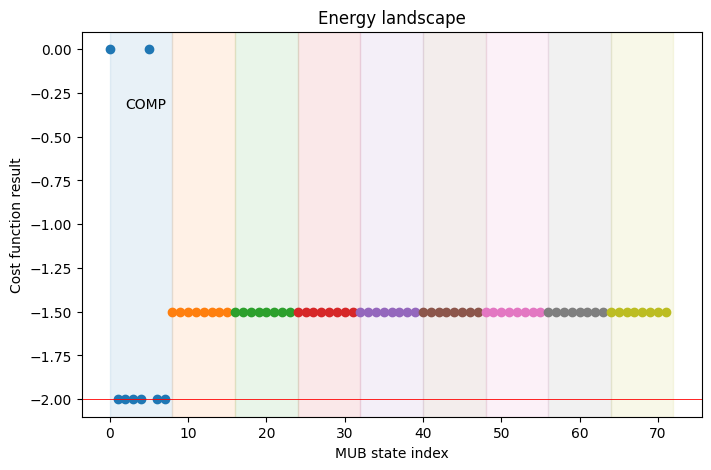

Energy Histogram:


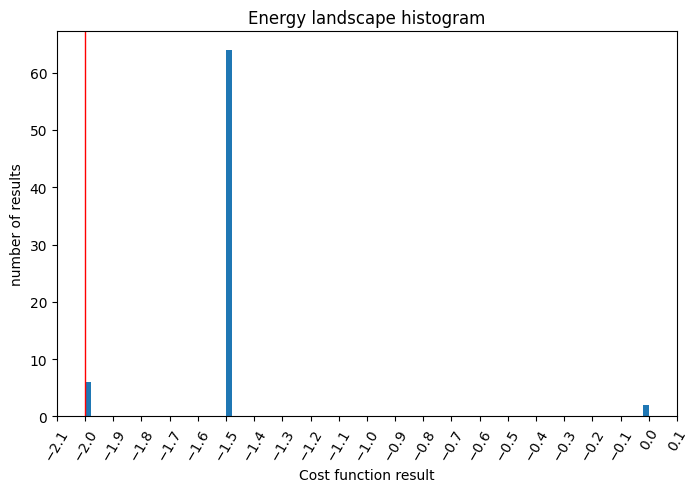

attempting all MUB states over the operator SparsePauliOp(['IZZ', 'ZZI', 'III'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -1. +0.j])
Energy Landscape:


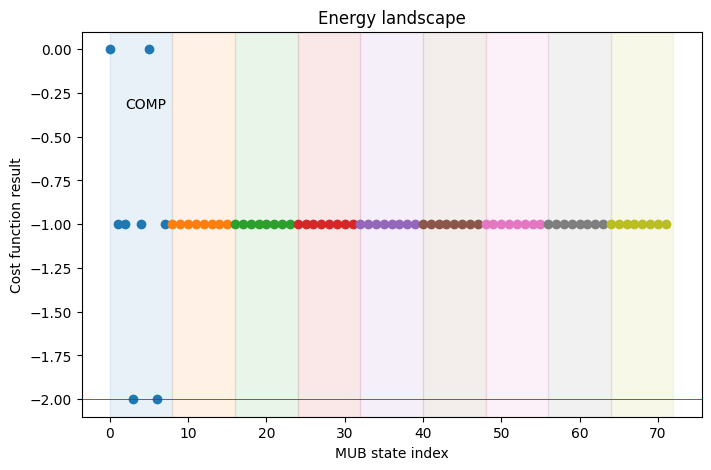

Energy Histogram:


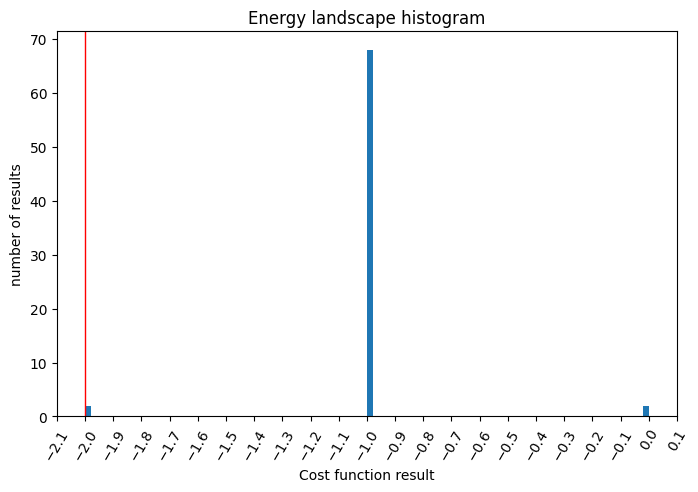

===Calculating Transverse Ising Landscapes===
attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.32383276+0.j, 0.32383276+0.j, 0.07243629+0.j, 0.07243629+0.j,
 0.07243629+0.j])
Energy Landscape:


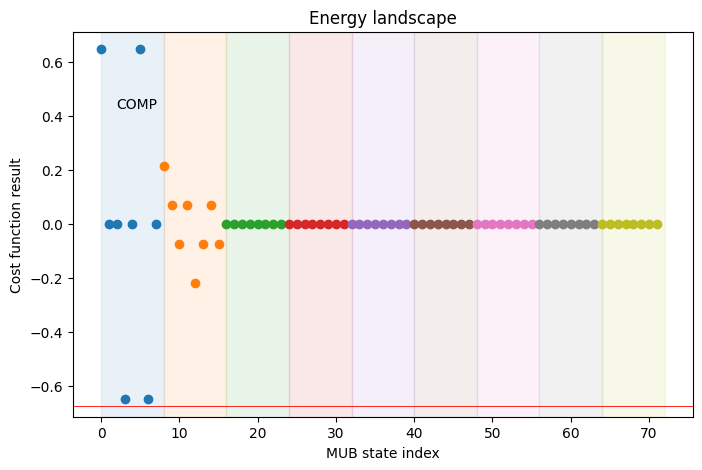

Energy Histogram:


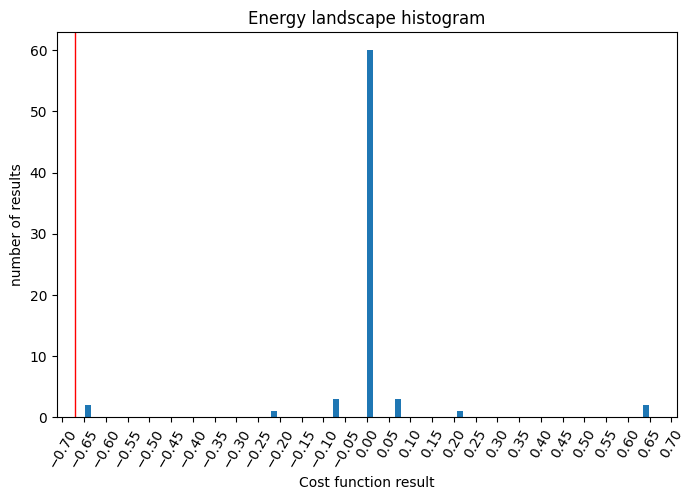

attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.15084917+0.j, 0.15084917+0.j, 0.535882  +0.j, 0.535882  +0.j,
 0.535882  +0.j])
Energy Landscape:


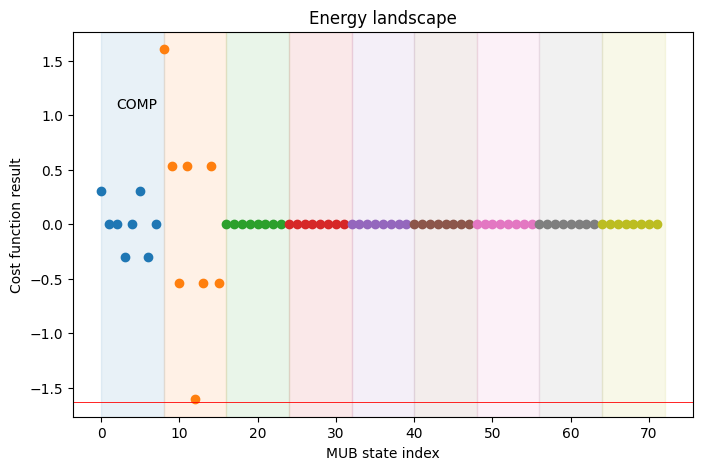

Energy Histogram:


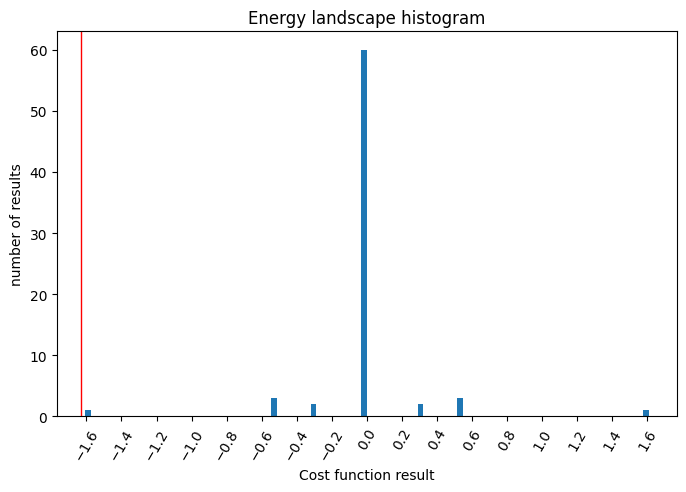

attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.65093447+0.j, 0.65093447+0.j, 0.36568892+0.j, 0.36568892+0.j,
 0.36568892+0.j])
Energy Landscape:


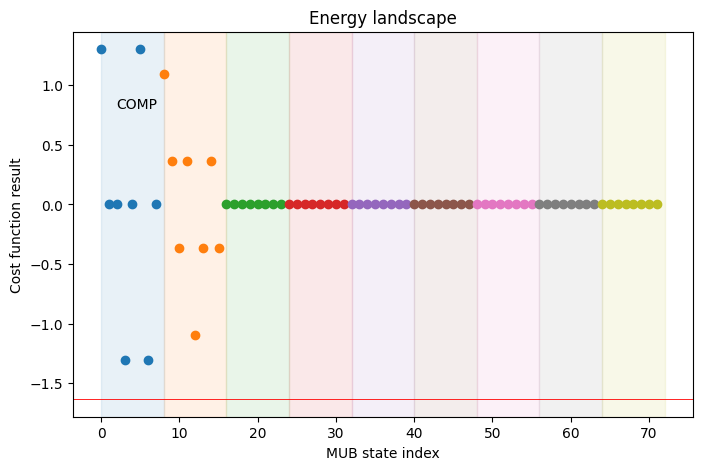

Energy Histogram:


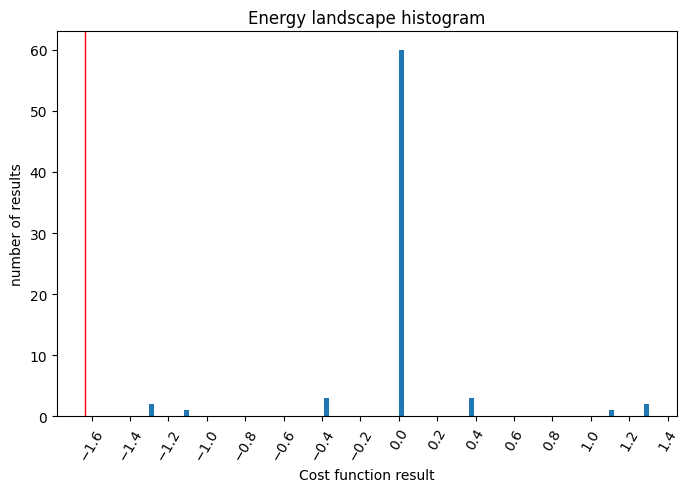

In [6]:

print("===Calculating Maxcut Landscapes===")
maxcut_landscapes = run_and_record_landscape_shifted_list(maxcut_hams, n_mub_qubits=3, ansatz=ansatz)
print("===Calculating Transverse Ising Landscapes===")
transverse_landscapes = run_and_record_landscape_shifted_list(transverse_hams, n_mub_qubits=3, ansatz=ansatz)


### VQE Runs

The operator SparsePauliOp(['IZZ', 'ZIZ', 'ZZI', 'III'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -1.5+0.j]) has the exact value -2.0.
Now trying to reach the value from different MUB points.
running from state of index subset 0, MUB 0, state 1 and value -2.0
10: -2.0
20: -2.0
30: -2.0
40: -1.9673823984917007
50: -1.9694480499803904
60: -1.9550969058919043
70: -1.9550969058919043
80: -1.9550969058919043
90: -1.9550969058919043
100: -1.9976301029069425
110: -1.9995555337341306
120: -1.9986435246810856
130: -1.9986435246810856
140: -1.9986435246810856
150: -1.9986435246810856
160: -1.9999652335517266
170: -1.999991436844581
180: -1.9999936596655596
190: -1.9999773156581782
200: -1.9999773156581782
210: -1.9999773156581782
220: -1.9999773156581782
230: -1.9999995494876677
240: -1.9999998886652512
250: -1.9999997618555174
260: -1.9999997618555174
270: -1.9999997618555174
280: -1.9999997618555174
290: -1.9999999916716766
300: -1.9999999990501038
310: -1.9999999962827273
320: -1.9

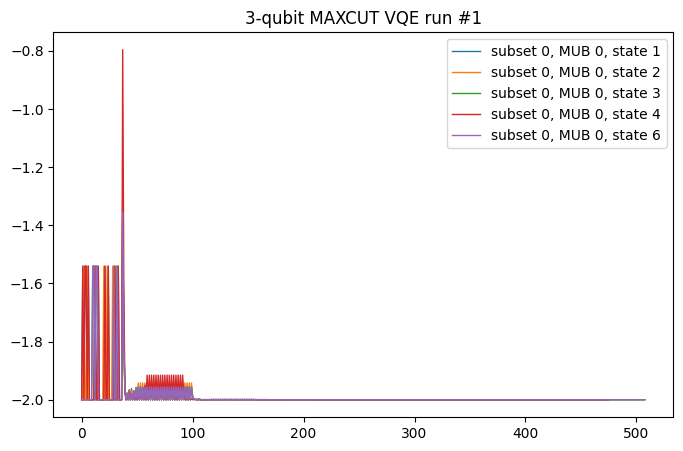

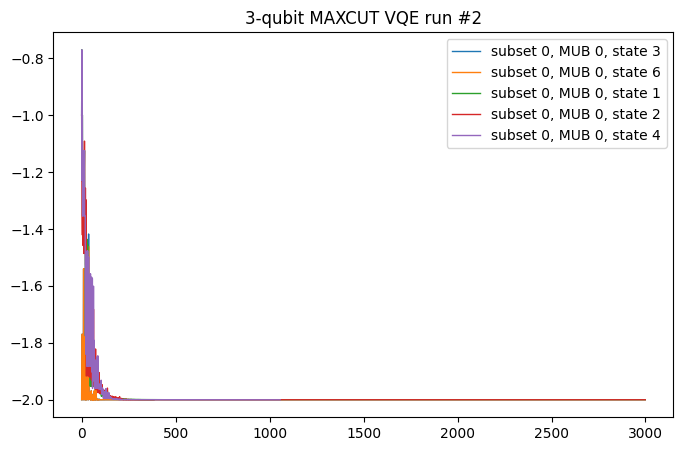

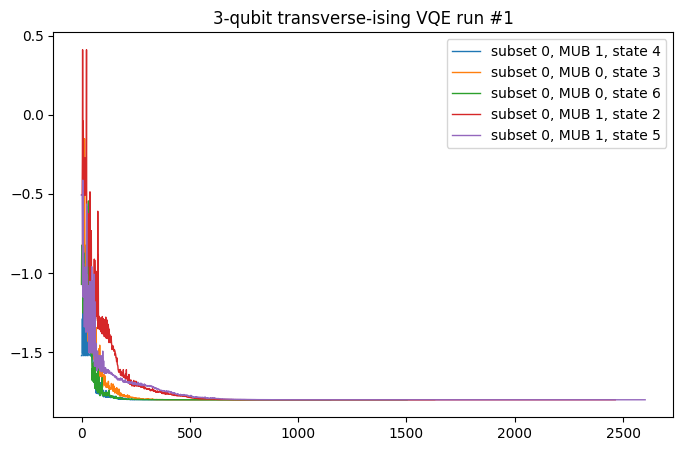

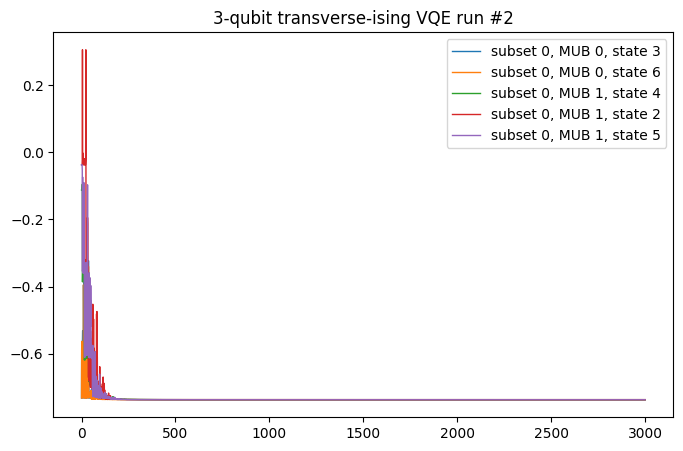

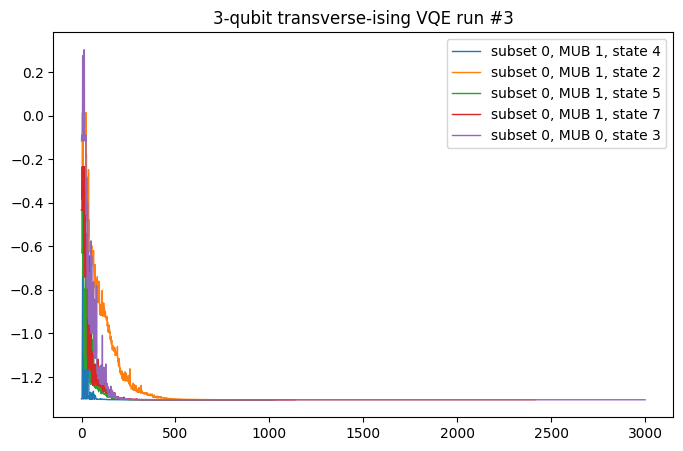

In [9]:
maxcut_vqe_runs = run_and_record_vqe_shifted_list(maxcut_landscapes, ansatz)
transverse_vqe_runs = run_and_record_vqe_shifted_list(transverse_landscapes, ansatz)   
plot_VQE_evals_list(maxcut_vqe_runs, "3-qubit MAXCUT VQE run")
plot_VQE_evals_list(transverse_vqe_runs, "3-qubit transverse-ising VQE run")

10: -0.6476655296663247
20: -0.6476655296663247
30: -0.34993517911002536
40: -0.6314001643163399
50: -0.6432815304306103
60: -0.6317273778234392
70: -0.648744627385534
80: -0.6457442458869493
90: -0.657895171500037
100: -0.6607802573940109
110: -0.6592188640541248
120: -0.6641068278481618
130: -0.6640686041068684
140: -0.6653034304425407
150: -0.665056400696475
160: -0.6655691656641168
170: -0.6662938088696421
180: -0.6660777132040187
190: -0.6664507453995445
200: -0.6669445583659886
210: -0.6671338859739361
220: -0.6671675726358212
230: -0.6674323127257283
240: -0.6674674152983414
250: -0.6675452219095421
260: -0.6675462000841303
270: -0.6676713941700981
280: -0.6676657249876048
290: -0.667649284902417
300: -0.6676208217562221
310: -0.6676630350277607
320: -0.6676915986510281
330: -0.6677215780356651
340: -0.6677541564705479
350: -0.6677628643710938
360: -0.6677919790658869
370: -0.6678093395691111
380: -0.6678243165212601
390: -0.6678278419465088
400: -0.6678394147960646
410: -0.6678

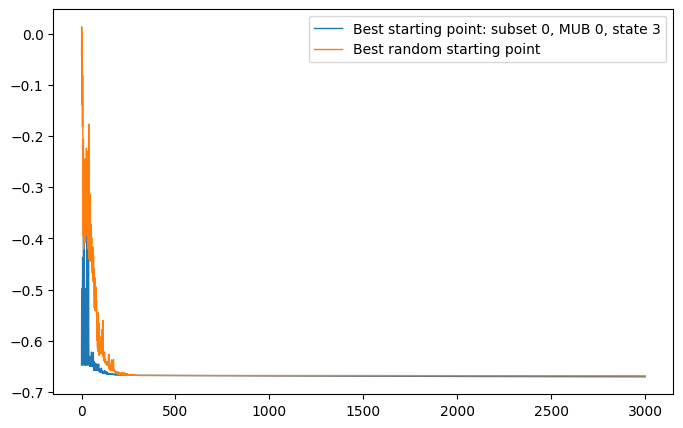

10: -0.8686148478004336
20: -1.607646012920067
30: -1.607646012920067
40: -1.5570333111594823
50: -1.5925982361457167
60: -1.607986795670664
70: -1.5824743067435934
80: -1.6131236455875133
90: -1.6101883576244584
100: -1.6224634898201677
110: -1.6184753682491673
120: -1.6246580807499484
130: -1.6259608660237999
140: -1.6253491753917477
150: -1.6269230871579428
160: -1.6255881991434373
170: -1.6254984613620513
180: -1.6268232989317815
190: -1.6279335197830873
200: -1.6282807960704238
210: -1.628372577728309
220: -1.6283903597661062
230: -1.6283226160659618
240: -1.6283954713442608
250: -1.6286821144045014
260: -1.6286716458364419
270: -1.6287774183272923
280: -1.628813888499506
290: -1.6288144858765343
300: -1.6288042620832401
310: -1.6288215260674717
320: -1.6288437818049026
330: -1.6288322608195944
340: -1.6288457237934595
350: -1.6288593495764738
360: -1.628860668220826
370: -1.628859706528147
380: -1.628867179287039
390: -1.6288667535098358
400: -1.6288712265694407
410: -1.628870715

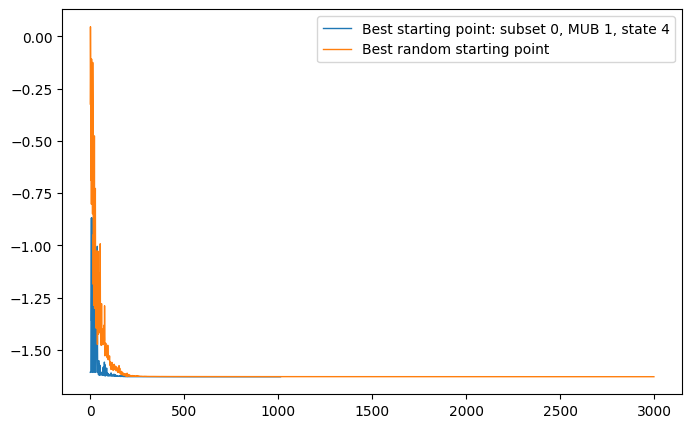

10: -1.3018689460797075
20: -1.3018689460797075
30: -0.8494430854426807
40: -1.296457297616525
50: -1.4231306400555324
60: -1.4481718511829114
70: -1.456091532559571
80: -1.4611785663356902
90: -1.5021917774865963
100: -1.5354132070814281
110: -1.5326848728884666
120: -1.5302287917258348
130: -1.5359253600117082
140: -1.5333817380560324
150: -1.5715625915954372
160: -1.571525217545569
170: -1.5726503793696014
180: -1.5740308014604067
190: -1.5781244782872483
200: -1.585420711771447
210: -1.5865162682606035
220: -1.5883765370975578
230: -1.5899244832848707
240: -1.5928646827756034
250: -1.5946041834818512
260: -1.5963296193229313
270: -1.598382209678834
280: -1.5990705811386894
290: -1.599374336473053
300: -1.6020607792114208
310: -1.6047912194317773
320: -1.6070296680346248
330: -1.6064583055155037
340: -1.6075304091844804
350: -1.607825954877599
360: -1.6110783374070168
370: -1.6117364739017748
380: -1.6120898822253653
390: -1.6163026560255553
400: -1.6175122092772982
410: -1.61909386

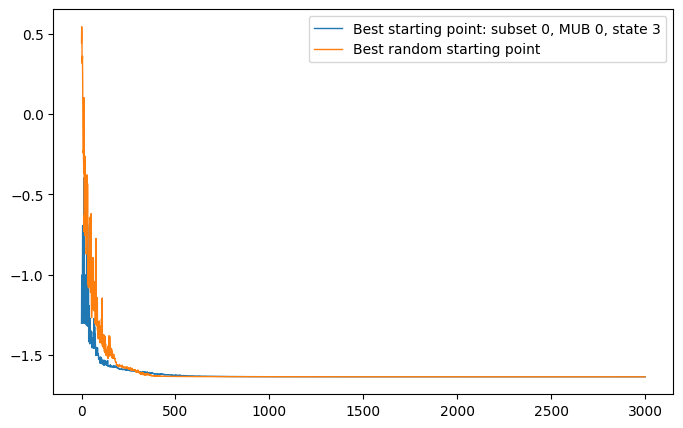

In [7]:
for transverse_landscape in transverse_landscapes:
    run_and_display_vqe_best_vs_random_shifted(transverse_landscape, ansatz, num_random=4)
    # run_and_display_vqe_best_and_worst_shifted(transverse_landscape, ansatz)

## >3 qubit experiments
These experiments are run on two types of examples:
-   Hamiltonian reductions of MAXCUT problem instances.
-   Transverse-Field Ising Model Hamiltonians.
-   **In addition**, the 4-qubit Molecular Hamiltonian will be landscaped here.

For these, we will present:
-   The energy landscape sampled using all partial-MUB states, with an appended ansatz.
-   VQE execution from the best 10 partial-MUB+ansatz states as initial points.

### Hamiltonian Generation

In [ ]:
# half-MUB experiments
n_mub_qubits = 3
n_qubits_list = list(range(4,9))

# Transverse Ising Hamiltonians
zz_coeffs = [random.uniform(0,1) for _ in n_qubits_list]
x_coeffs = [random.uniform(0,1) for _ in n_qubits_list]
transverse_ham_params = zip(n_qubits_list, zz_coeffs, x_coeffs)

LiH_ham_1_5 = SparsePauliOp(
    data= ['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII',
    'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ', 'IZZX', 'IZIX', 'IZXX', 'IZYY', 'ZXIZ', 'IXIZ', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'ZXXX',
    'IXXX', 'ZXYY', 'IXYY', 'XXIZ', 'YYIZ', 'XXZX', 'YYZX', 'XXIX', 'YYIX', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'ZZIZ', 'ZZZX', 'ZZIX',
    'ZZXX', 'ZZYY', 'XZIZ', 'XIIZ', 'XZZX', 'XIZX', 'XZIX', 'XIIX', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'ZIIZ', 'ZIZX', 'ZIIX', 'ZIXX',
    'ZIYY', 'IZZZ', 'IZXZ', 'IZXI', 'ZXZZ', 'IXZZ', 'ZXXZ', 'IXXZ', 'ZXXI', 'IXXI', 'XXZZ', 'YYZZ', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI',
    'ZZZZ', 'ZZXZ', 'ZZXI', 'XZZZ', 'XIZZ', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'ZIZZ', 'ZIXZ', 'ZIXI', 'IZZI', 'ZXZI', 'IXZI', 'XXZI',
    'YYZI', 'ZZZI', 'XZZI', 'XIZI', 'ZIZI'], 
coeffs = [-1.99754128e-01+0.j, -9.17966069e-02+0.j, -2.73410751e-03+0.j,
        2.73410751e-03+0.j, -3.09895035e-04+0.j,  3.09895035e-04+0.j,  -2.11959340e-01+0.j,  1.95776538e-02+0.j,  1.95776538e-02+0.j,
        3.71356404e-01+0.j,  9.17966069e-02+0.j,  2.73410751e-03+0.j, 2.73410751e-03+0.j, -3.09895035e-04+0.j,  3.09895035e-04+0.j,
       -2.11959340e-01+0.j, -1.95776538e-02+0.j,  1.95776538e-02+0.j, -3.71356404e-01+0.j, -1.23570872e-01+0.j,  1.17336239e-02+0.j,
       -1.17336239e-02+0.j,  3.30587286e-02+0.j, -3.30587286e-02+0.j, 1.17336239e-02+0.j,  1.17336239e-02+0.j, -3.03465683e-03+0.j,
       -3.03465683e-03+0.j,  3.03465683e-03+0.j,  3.03465683e-03+0.j, -8.37336142e-03+0.j, -8.37336142e-03+0.j,  8.37336142e-03+0.j,
        8.37336142e-03+0.j, -3.30587286e-02+0.j,  3.30587286e-02+0.j, 8.37336142e-03+0.j, -8.37336142e-03+0.j, -8.37336142e-03+0.j,
        8.37336142e-03+0.j,  3.07383272e-02+0.j, -3.07383272e-02+0.j, -3.07383272e-02+0.j,  3.07383272e-02+0.j,  5.66560676e-02+0.j,
        1.54067009e-03+0.j, -1.54067009e-03+0.j,  2.36793690e-03+0.j, -2.36793690e-03+0.j, -1.27339140e-02+0.j,  1.27339140e-02+0.j,
        2.11113767e-03+0.j, -2.11113767e-03+0.j, -2.11113767e-03+0.j, 2.11113767e-03+0.j,  7.76444118e-03+0.j, -7.76444118e-03+0.j,
       -7.76444118e-03+0.j,  7.76444118e-03+0.j,  1.14339547e-01+0.j, -1.05401874e-02+0.j,  1.05401874e-02+0.j, -3.51167704e-02+0.j,
        3.51167704e-02+0.j, -5.66560676e-02+0.j, -1.27339140e-02+0.j, -1.27339140e-02+0.j, -1.54067009e-03+0.j, -1.54067009e-03+0.j,
        2.11113767e-03+0.j,  2.11113767e-03+0.j,  2.11113767e-03+0.j, 2.11113767e-03+0.j,  2.36793690e-03+0.j, -2.36793690e-03+0.j,
       -7.76444118e-03+0.j,  7.76444118e-03+0.j, -7.76444118e-03+0.j, 7.76444118e-03+0.j,  8.47039180e-02+0.j, -9.01204279e-03+0.j,
       -9.01204279e-03+0.j,  9.01204279e-03+0.j, -9.01204279e-03+0.j, -6.57574490e-03+0.j,  6.57574490e-03+0.j, -6.57574490e-03+0.j,
        6.57574490e-03+0.j,  6.05056057e-02+0.j,  1.08894077e-02+0.j, 1.08894077e-02+0.j,  1.14339547e-01+0.j, -1.05401874e-02+0.j,
       -1.05401874e-02+0.j,  3.51167704e-02+0.j, -3.51167704e-02+0.j, -6.05056057e-02+0.j,  1.08894077e-02+0.j, -1.08894077e-02+0.j,
       -1.14091635e-01+0.j]
)
molecular_ground_energy = get_exact_ground(LiH_ham_1_5)

transverse_hams = [gen_trans_ising_op(*ham_params) for ham_params in transverse_ham_params]
transverse_ground_energies = [get_exact_ground(op) for op in transverse_hams]


# MAXCUT Hamiltonians
rand_graph_4 = nx.gnm_random_graph(4, 5)
rand_graph_5 = nx.gnm_random_graph(5, 9)
rand_graph_6 = nx.gnm_random_graph(6, 12)
rand_graph_7 = nx.gnm_random_graph(7, 12)
rand_graph_8 = nx.gnm_random_graph(8, 14)
graphs = [rand_graph_4, rand_graph_5, rand_graph_6, rand_graph_7, rand_graph_8]
maxcut_hams = [gen_maxcut_op_from_graph(graph) for graph in graphs]
maxcut_exact_results = [get_exact_ground(op) for op in maxcut_hams]

# ansatzes = [TwoLocal(n, ['rx', 'ry', 'rz'], 'cx', 'linear', reps=n, insert_barriers=True).decompose() for n in n_qubits_list]


### Calculate Landscape

===Calculating Molecular Landscapes===
attempting all MUB states over the operator SparsePauliOp(['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII', 'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ', 'IZZX', 'IZIX', 'IZXX', 'IZYY', 'ZXIZ', 'IXIZ', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'ZXXX', 'IXXX', 'ZXYY', 'IXYY', 'XXIZ', 'YYIZ', 'XXZX', 'YYZX', 'XXIX', 'YYIX', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'ZZIZ', 'ZZZX', 'ZZIX', 'ZZXX', 'ZZYY', 'XZIZ', 'XIIZ', 'XZZX', 'XIZX', 'XZIX', 'XIIX', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'ZIIZ', 'ZIZX', 'ZIIX', 'ZIXX', 'ZIYY', 'IZZZ', 'IZXZ', 'IZXI', 'ZXZZ', 'IXZZ', 'ZXXZ', 'IXXZ', 'ZXXI', 'IXXI', 'XXZZ', 'YYZZ', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI', 'ZZZZ', 'ZZXZ', 'ZZXI', 'XZZZ', 'XIZZ', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'ZIZZ', 'ZIXZ', 'ZIXI', 'IZZI', 'ZXZI', 'IXZI', 'XXZI', 'YYZI', 'ZZZI', 'XZZI', 'XIZI', 'ZIZI'],
              coeffs=[-1.99754128e-01+0.j, -9.17966069e-02+0.j, -2.73410751e-03+0.j,
  2.73410751e-03

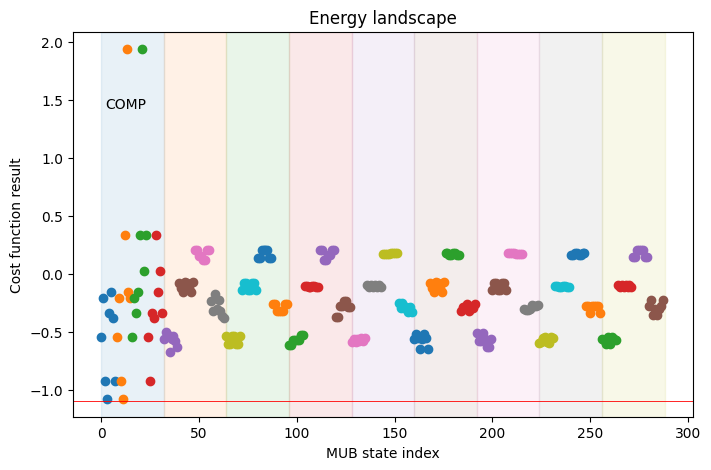

Energy Histogram:


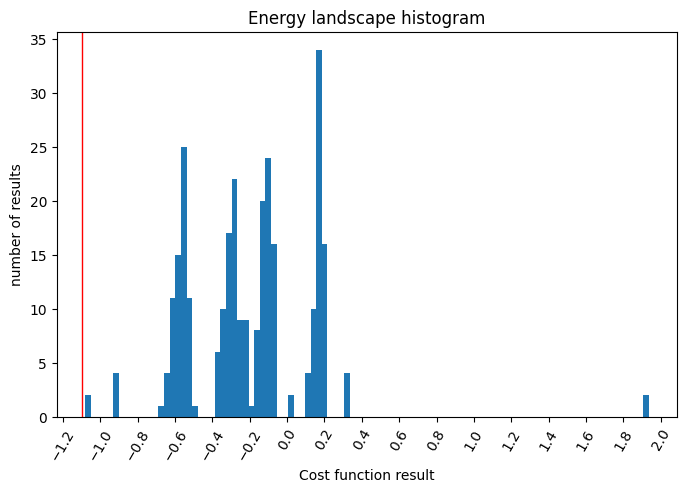

===Calculating Transverse Landscapes===
attempting all MUB states over the operator SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[0.06985542+0.j, 0.06985542+0.j, 0.06985542+0.j, 0.22323896+0.j,
 0.22323896+0.j, 0.22323896+0.j, 0.22323896+0.j])
Energy Landscape:


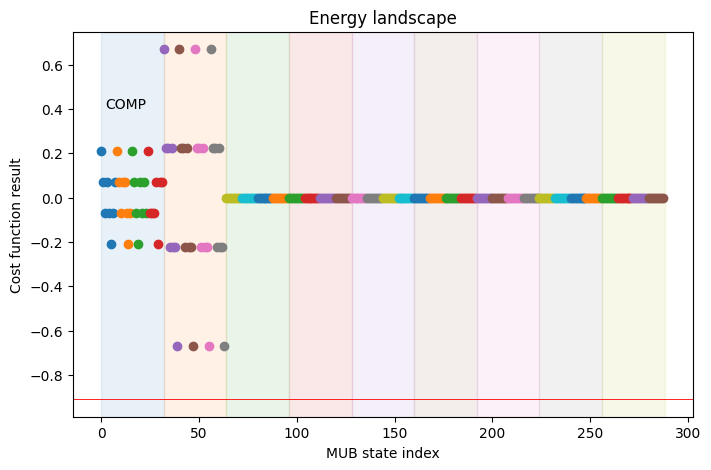

Energy Histogram:


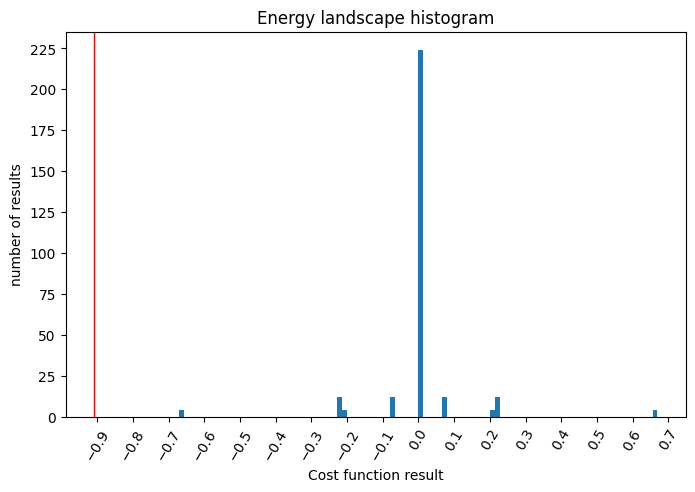

attempting all MUB states over the operator SparsePauliOp(['ZZIII', 'IZZII', 'IIZZI', 'IIIZZ', 'XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'],
              coeffs=[0.09071301+0.j, 0.09071301+0.j, 0.09071301+0.j, 0.09071301+0.j,
 0.62743322+0.j, 0.62743322+0.j, 0.62743322+0.j, 0.62743322+0.j,
 0.62743322+0.j])
Energy Landscape:


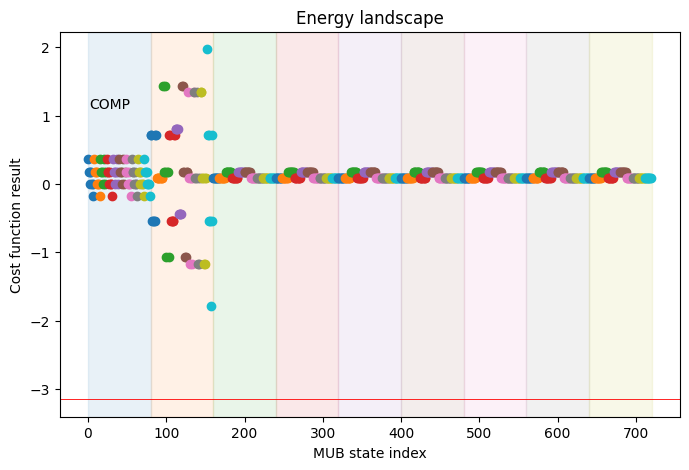

Energy Histogram:


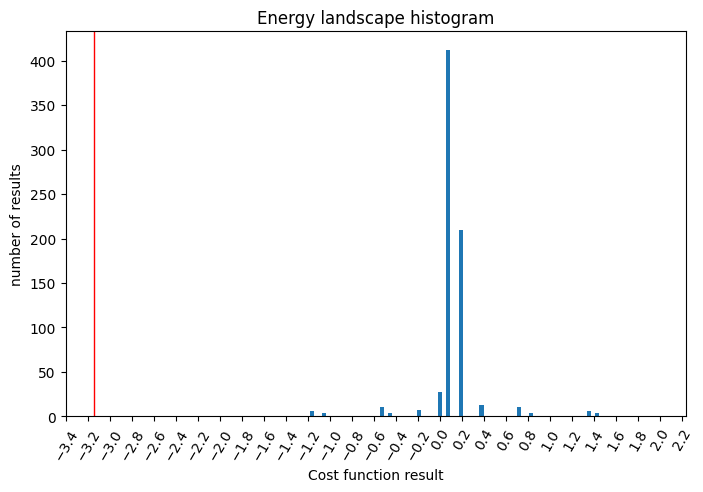

attempting all MUB states over the operator SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[0.42451919+0.j, 0.42451919+0.j, 0.42451919+0.j, 0.42451919+0.j,
 0.42451919+0.j, 0.94770894+0.j, 0.94770894+0.j, 0.94770894+0.j,
 0.94770894+0.j, 0.94770894+0.j, 0.94770894+0.j])
Energy Landscape:


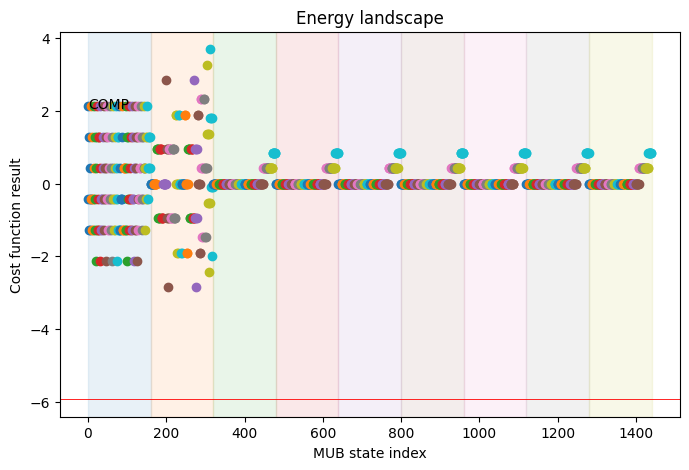

Energy Histogram:


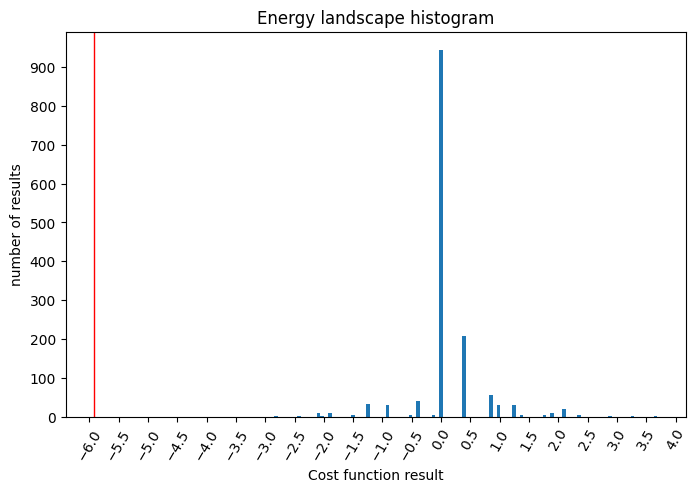

attempting all MUB states over the operator SparsePauliOp(['ZZIIIII', 'IZZIIII', 'IIZZIII', 'IIIZZII', 'IIIIZZI', 'IIIIIZZ', 'XIIIIII', 'IXIIIII', 'IIXIIII', 'IIIXIII', 'IIIIXII', 'IIIIIXI', 'IIIIIIX'],
              coeffs=[0.82685212+0.j, 0.82685212+0.j, 0.82685212+0.j, 0.82685212+0.j,
 0.82685212+0.j, 0.82685212+0.j, 0.57710295+0.j, 0.57710295+0.j,
 0.57710295+0.j, 0.57710295+0.j, 0.57710295+0.j, 0.57710295+0.j,
 0.57710295+0.j])
Energy Landscape:


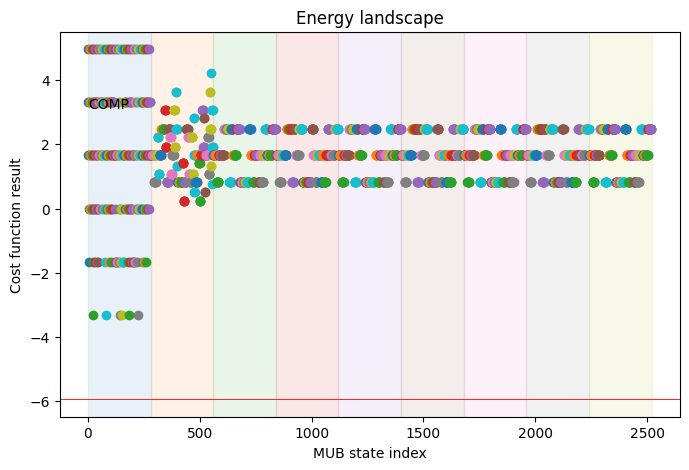

Energy Histogram:


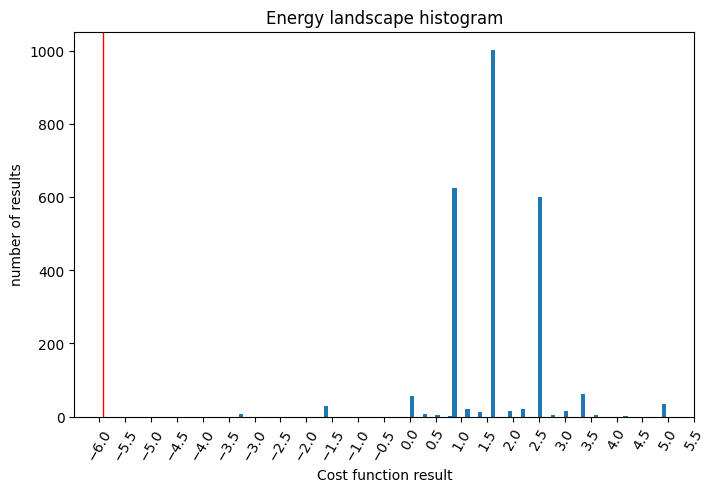

attempting all MUB states over the operator SparsePauliOp(['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ', 'XIIIIIII', 'IXIIIIII', 'IIXIIIII', 'IIIXIIII', 'IIIIXIII', 'IIIIIXII', 'IIIIIIXI', 'IIIIIIIX'],
              coeffs=[0.12380196+0.j, 0.12380196+0.j, 0.12380196+0.j, 0.12380196+0.j,
 0.12380196+0.j, 0.12380196+0.j, 0.12380196+0.j, 0.39668047+0.j,
 0.39668047+0.j, 0.39668047+0.j, 0.39668047+0.j, 0.39668047+0.j,
 0.39668047+0.j, 0.39668047+0.j, 0.39668047+0.j])
Energy Landscape:


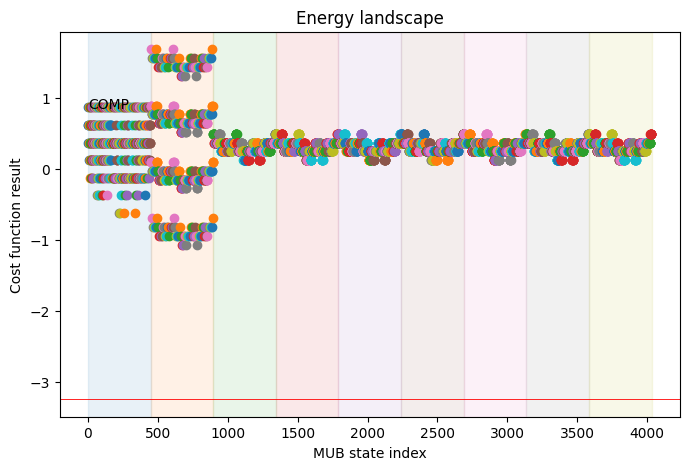

Energy Histogram:


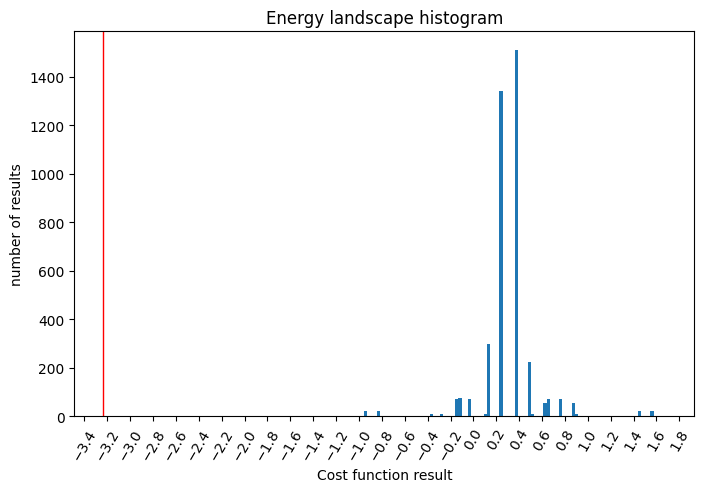

===Calculating Maxcut Landscapes===
attempting all MUB states over the operator SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIZI', 'ZZII', 'IIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -2.5+0.j])
Energy Landscape:


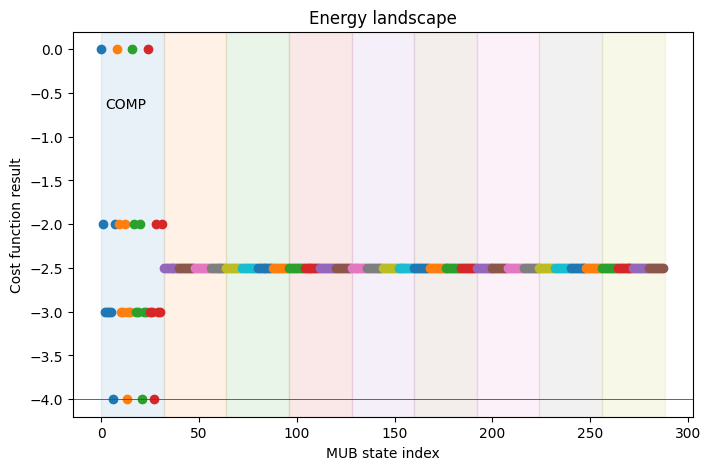

Energy Histogram:


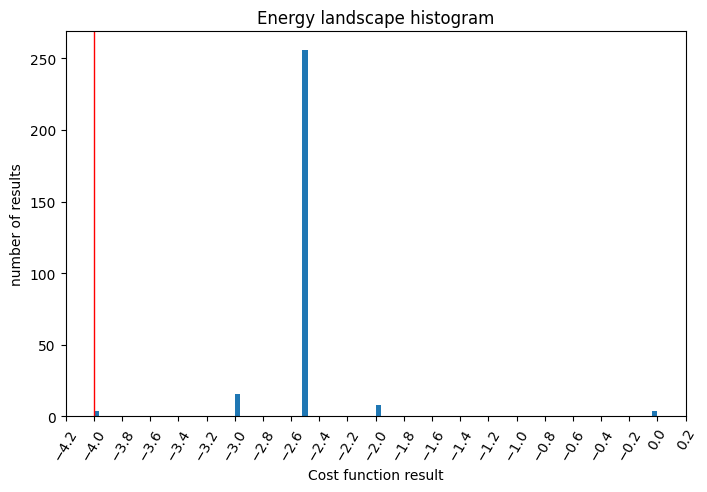

attempting all MUB states over the operator SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'IZZII', 'ZIZII', 'ZZIII', 'IIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j, -4.5+0.j])
Energy Landscape:


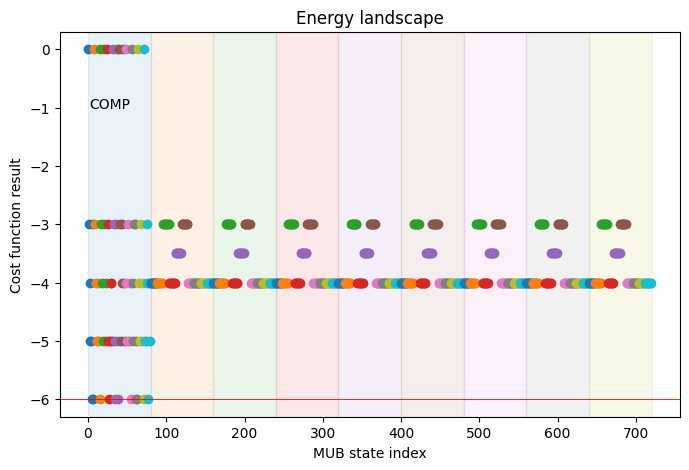

Energy Histogram:


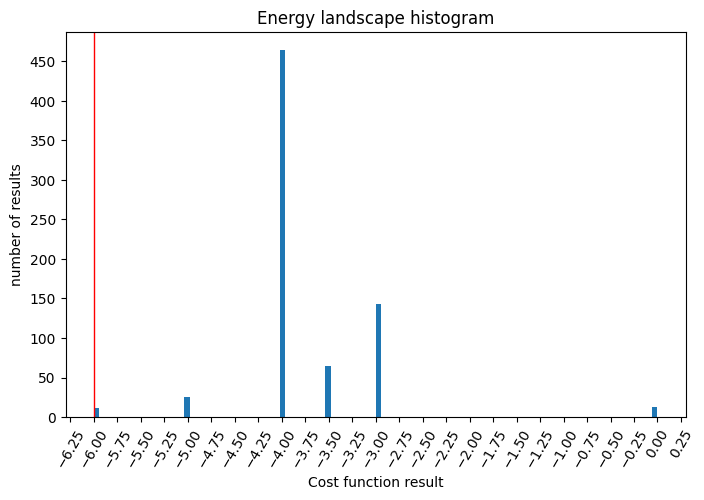

attempting all MUB states over the operator SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'ZIZIII', 'ZZIIII', 'IIIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -6. +0.j])
Energy Landscape:


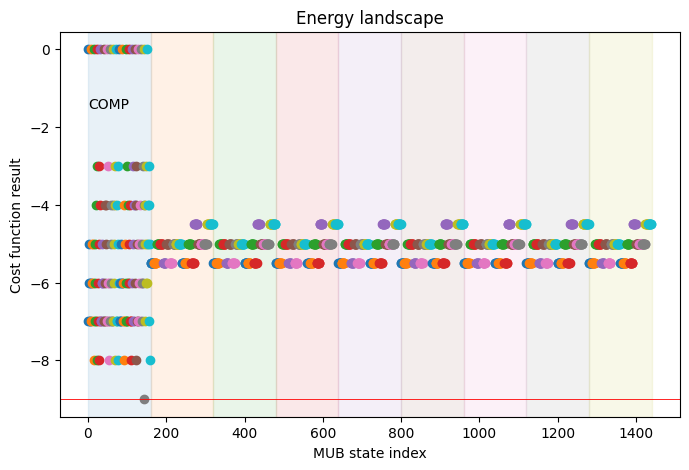

Energy Histogram:


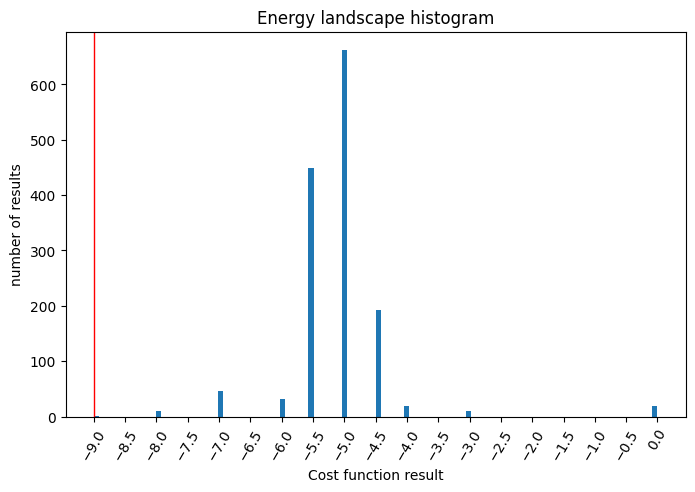

attempting all MUB states over the operator SparsePauliOp(['IIIIIZZ', 'IIZIIIZ', 'IZIIIIZ', 'ZIIIIIZ', 'IIZIIZI', 'IZIIIZI', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIZIII', 'ZIZIIII', 'ZZIIIII', 'IIIIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -6. +0.j])
Energy Landscape:


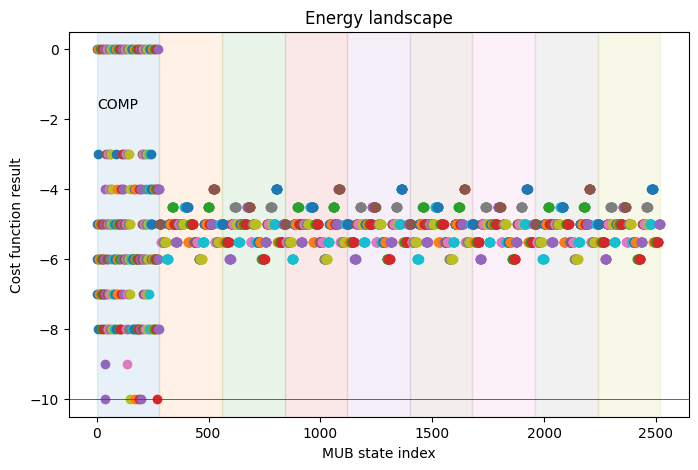

Energy Histogram:


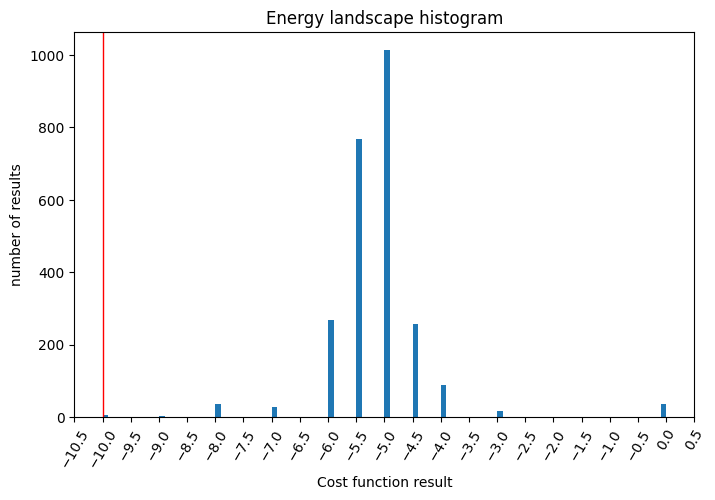

attempting all MUB states over the operator SparsePauliOp(['ZIIIIIIZ', 'IIIIZIZI', 'IZIIIIZI', 'IIZIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII', 'IIIIIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
 -7. +0.j])
Energy Landscape:


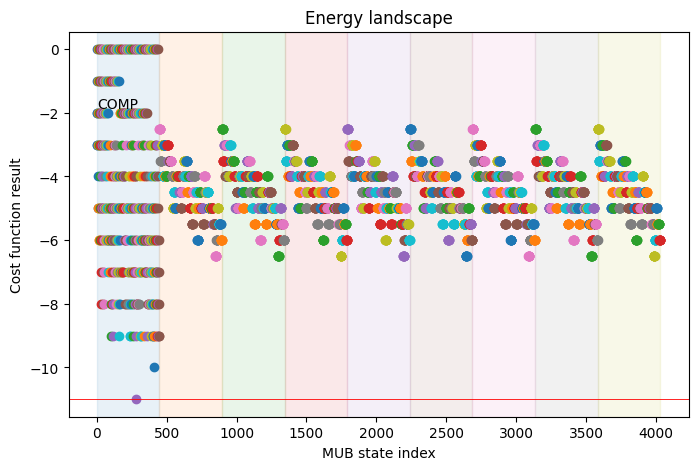

Energy Histogram:


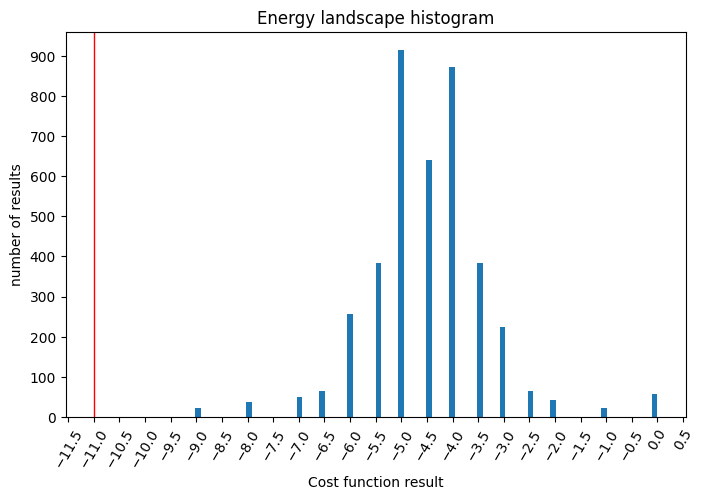

In [ ]:
print("===Calculating Molecular Landscapes===")
n_qubits = LiH_ham_1_5.num_qubits 
ansatz = get_twolocal(n_qubits, n_qubits)
LiH_landscape = run_and_record_landscape_shifted(LiH_ham_1_5, n_mub_qubits, ansatz)

print("===Calculating Transverse Landscapes===")
transverse_landscapes = []
for n_qubits, ham in zip(n_qubits_list, transverse_hams):
    ansatz = get_twolocal(n_qubits, n_qubits)
    transverse_landscapes.append(run_and_record_landscape_shifted(ham, n_mub_qubits, ansatz))

print("===Calculating Maxcut Landscapes===")
maxcut_landscapes = []
for n_qubits, ham in zip(n_qubits_list, maxcut_hams):
    ansatz = get_twolocal(n_qubits, n_qubits)
    maxcut_landscapes.append(run_and_record_landscape_shifted(ham, n_mub_qubits, ansatz))

### VQE Runs

In [ ]:
n_qubits = LiH_ham_1_5.num_qubits
ansatz = get_twolocal(n_qubits, n_qubits) 
molecular_vqe_res = run_and_record_vqe_shifted(LiH_landscape, ansatz, record_progress=False)

The operator SparsePauliOp(['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII', 'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ', 'IZZX', 'IZIX', 'IZXX', 'IZYY', 'ZXIZ', 'IXIZ', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'ZXXX', 'IXXX', 'ZXYY', 'IXYY', 'XXIZ', 'YYIZ', 'XXZX', 'YYZX', 'XXIX', 'YYIX', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'ZZIZ', 'ZZZX', 'ZZIX', 'ZZXX', 'ZZYY', 'XZIZ', 'XIIZ', 'XZZX', 'XIZX', 'XZIX', 'XIIX', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'ZIIZ', 'ZIZX', 'ZIIX', 'ZIXX', 'ZIYY', 'IZZZ', 'IZXZ', 'IZXI', 'ZXZZ', 'IXZZ', 'ZXXZ', 'IXXZ', 'ZXXI', 'IXXI', 'XXZZ', 'YYZZ', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI', 'ZZZZ', 'ZZXZ', 'ZZXI', 'XZZZ', 'XIZZ', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'ZIZZ', 'ZIXZ', 'ZIXI', 'IZZI', 'ZXZI', 'IXZI', 'XXZI', 'YYZI', 'ZZZI', 'XZZI', 'XIZI', 'ZIZI'],
              coeffs=[-1.99754128e-01+0.j, -9.17966069e-02+0.j, -2.73410751e-03+0.j,
  2.73410751e-03+0.j, -3.09895035e-04+0.j,  3.09895035e-04+0.j,
 -2.11959340e-01+0.j, 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Traceback (most recent call last):
  File "/Users/ittay/venvs/quantum/lib/python3.12/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = sf.fun(x)
        ^^^^^^^^^
  File "/Users/ittay/venvs/quantum/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 278, in fun
    self._update_fun()
  File "/Users/ittay/venvs/quantum/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun
    self._update_fun_impl()
  File "/Users/ittay/venvs/quantum/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 163, in update_fun
    self.f = fun_wrapped(self.x)
             ^^^^^^^^^^^^^^^^^^^
  File "/Users/ittay/venvs/quantum/lib/python3.12/site-packages/scipy/optimize/_diff

: 

In [1]:


print("===Performing Transverse-Ising VQE===")
for n_qubits, landscape in zip(n_qubits_list, transverse_landscapes):
    ansatz = get_twolocal(n_qubits, n_qubits)   
    run_and_record_vqe_shifted(landscape, ansatz)


print("===Performing MAXCUT VQE===")
for n_qubits, landscape in zip(n_qubits_list, maxcut_landscapes):
    ansatz = get_twolocal(n_qubits, n_qubits)
    run_and_record_vqe_shifted(landscape, ansatz)

===Performing Transverse-Ising VQE===


NameError: name 'n_qubits_list' is not defined